# Statistical Rethinking

## Homework Week 2


In [1]:
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import pandas as pd


### Problem 1

People get heavier with age. Assume that age influences weight through two paths. First, age
influences height, and height influences weight. This is an indirect influence of age on weight.
Second, age also directly influences weight through age-related changes in muscle growth and
body proportions. Draw the DAG that represents these causal relationships. And then write
a generative simulation that takes age as an input and simulates height and weight, obeying
the relationships in the DAG.

#### Answer

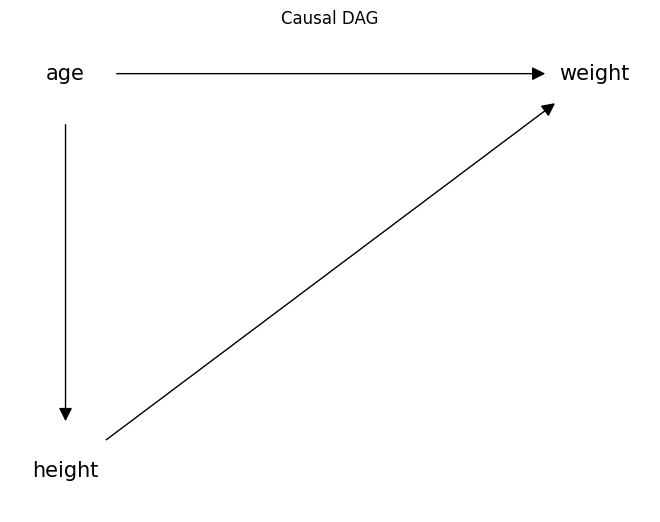

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(["age", "height", "weight"])

# Add edges
G.add_edges_from([("age", "height"), ("height", "weight"), ("age", "weight")])

# Draw the graph
nx.draw(G, pos={"age": (0,1), "height": (0,0), "weight": (1,1)}, with_labels=True, node_size=5000, node_color="white", font_size=15, font_weight="light", arrowsize=20)
plt.title("Causal DAG")
plt.show()

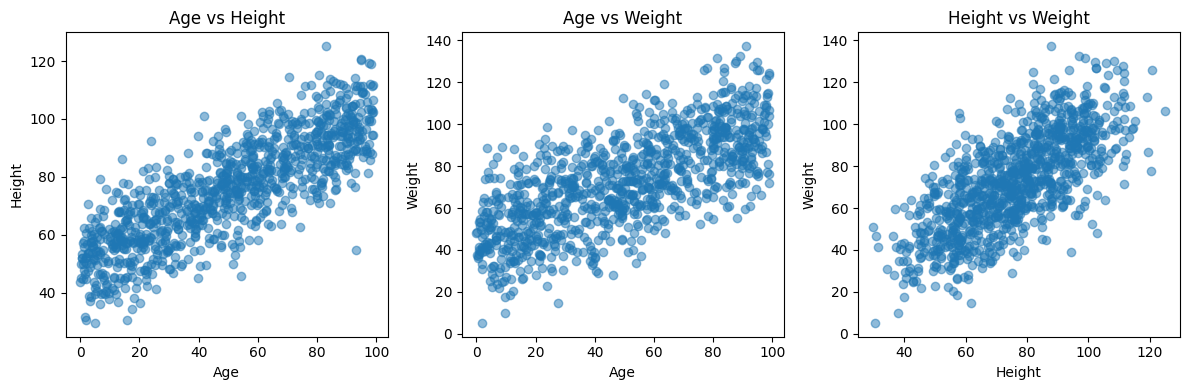

In [3]:
def model():
    # We model age is a real variable uniformly distributed between 0 and 99
    age = pyro.sample("age", dist.Uniform(0., 99.))
    
    # Height is Gaussian distributed with mean and std dependent on age
    height_mean = 50 + 0.5 * age
    height_std = 10.0
    height = pyro.sample("height", dist.Normal(height_mean, height_std))
    
    # Weight is Gaussian distributed with mean dependent on age and height
    weight_mean = 20 + 0.3 * age + 0.5 * height
    weight_std = 15.0
    weight = pyro.sample("weight", dist.Normal(weight_mean, weight_std))
    
    return age, height, weight

# Generate samples
num_samples = 1000
ages = []
heights = []
weights = []

for _ in range(num_samples):
    age, height, weight = model()
    ages.append(age.item())
    heights.append(height.item())
    weights.append(weight.item())

# Create scatter plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(ages, heights, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Height')
plt.title('Age vs Height')

plt.subplot(1, 3, 2)
plt.scatter(ages, weights, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Weight')
plt.title('Age vs Weight')

plt.subplot(1, 3, 3)
plt.scatter(heights, weights, alpha=0.5)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height vs Weight')

plt.tight_layout()
plt.show()

### Problem 2

Using the Howell 1 dataset, consider only the people younger than 13 years old. In this
sample, estimate the total causal effect of each year of growth on weight. What role does height have in this analysis?

#### Answer

Let's have a look at the data.

In [12]:
df = pd.read_csv("../data/Howell1.csv", delimiter=";", dtype={"height":	float, "weight": float, "age":	float, "male": int})
df = df[df["age"] < 13]
df = df.rename({"male": "sex"}, axis=1)
df["sex"] = pd.Categorical.from_codes(df["sex"], ["female", "male"])  # being more inclusive :)
df = df.sort_values("age") # for nicer display only
df

,height,weight,age,sex
542,71.1200,8.051258,0.0,male
467,60.9600,6.236890,0.0,male
466,55.8800,4.847765,0.0,female
517,53.9750,4.252425,0.0,female
462,62.2300,7.257472,0.0,female
...,...,...,...,...
272,127.0000,21.488921,12.0,female
337,140.6398,28.859791,12.0,male
375,123.1900,20.014747,12.0,male
81,137.7950,27.584063,12.0,female


This also has a "sex" category. Seems like we need to re-write the generative model to include sex too. We could use the respective DAG from the lecture:

![none](../assets/h2/causal-dag-with-sex.png)

Speaking of lecture, we could also use a more sophisticated model for the age-height relationship:

![none](../assets/h2/age-height-curve.png)

Here is the new model, implemented using pyro:

(50.0, 180.0)

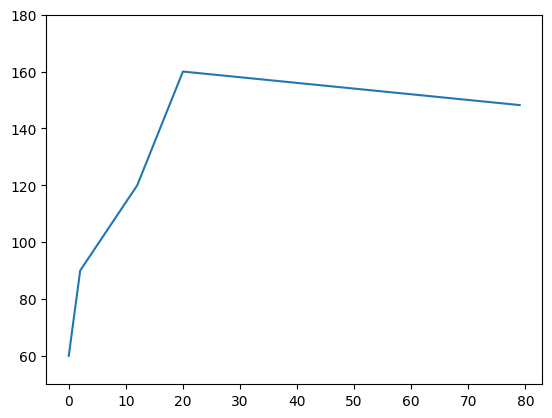

In [5]:
import numpy as np
import torch

def growth_curve(x):
    return torch.max(torch.zeros_like(x), x)*(30/2) \
        + torch.max(torch.zeros_like(x), x-2)*(-30/2+30/10) \
        + torch.max(torch.zeros_like(x), x-12)*(-30/10+40/8) \
        + torch.max(torch.zeros_like(x), x-20)*(-40/8-0.2) + 60

x = torch.arange(80)
_ = plt.plot(x, growth_curve(x))
plt.ylim(50, 180)


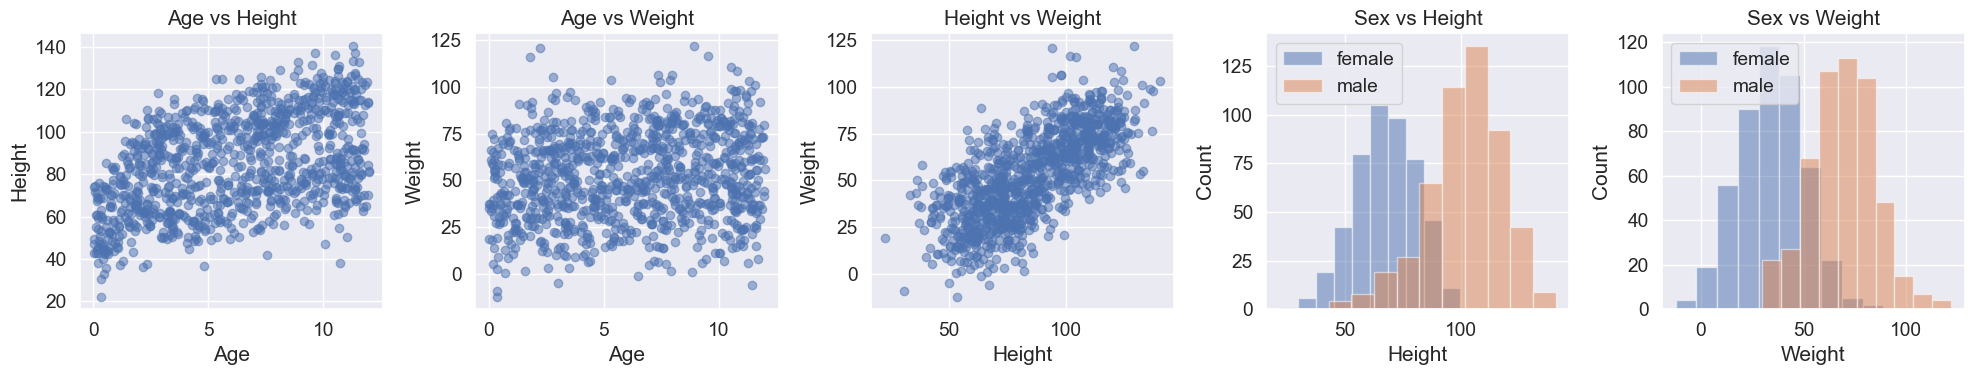

In [ ]:
def model(age_obs=None, height_obs=None, weight_obs=None, sex_obs=None):

    # what we choose as the priors for the root nodes would in practice depend on 
    # the "age structure" of the group of people we are investigating. 
    # This can be very different for different countries for example.
    # So, we can just as well use simple ones.
    with pyro.plate("participants"):
        sex = pyro.sample("sex", dist.Categorical(torch.tensor([0.5, 0.5])), obs=sex_obs)
        age = pyro.sample("age", dist.Uniform(0., 12.), obs=age_obs)
    
    # Height is Gaussian distributed with mean and std dependent on age
    height_mean = growth_curve(age)
    height_mean = torch.where(sex == 1, height_mean, height_mean*2/3)
    height_std = 10.0
    with pyro.plate("participants"):
        height = pyro.sample("height", dist.Normal(height_mean, height_std), obs=height_obs)
    
    # Weight is Gaussian distributed with mean dependent on age and height
    weight_mean = 20 - 0.3 * age + 0.5 * height
    weight_mean = torch.where(sex == 1, weight_mean, weight_mean*2/3)
    weight_std = 15.0
    with pyro.plate("participants"):
        weight = pyro.sample("weight", dist.Normal(weight_mean, weight_std), obs=weight_obs)

    return age, height, weight, sex

# Generate samples
num_samples = 1000
ages = []
heights = []
weights = []
sexes = []

for _ in range(num_samples):
    age, height, weight, sex = model()
    ages.append(age.item())
    heights.append(height.item())
    weights.append(weight.item())
    sexes.append(sex.item())

# Create scatter plots
plt.figure(figsize=(20, 4))

plt.subplot(1, 5, 1)
plt.scatter(ages, heights, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Height')
plt.title('Age vs Height')

plt.subplot(1, 5, 2)
plt.scatter(ages, weights, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Weight')
plt.title('Age vs Weight')

plt.subplot(1, 5, 3)
plt.scatter(heights, weights, alpha=0.5)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height vs Weight')

plt.subplot(1, 5, 4)
female_weights = [w for s, w in zip(sexes, heights) if s==0]
male_weights = [w for s, w in zip(sexes, heights) if s==1]
plt.hist(female_weights, stacked=True, alpha=0.5, label="female")
plt.hist(male_weights, stacked=True, alpha=0.5, label="male")
plt.xlabel('Height')
plt.ylabel('Count')
plt.title('Sex vs Height')
plt.legend()

plt.subplot(1, 5, 5)
female_weights = [w for s, w in zip(sexes, weights) if s==0]
male_weights = [w for s, w in zip(sexes, weights) if s==1]
plt.hist(female_weights, stacked=True, alpha=0.5, label="female")
plt.hist(male_weights, stacked=True, alpha=0.5, label="male")
plt.xlabel('Weight')
plt.ylabel('Count')
plt.title('Sex vs Weight')
plt.legend()

plt.tight_layout()
plt.show()

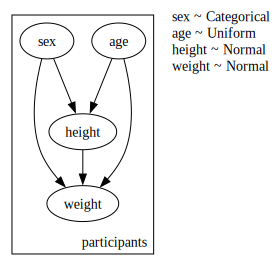

In [26]:
pyro.render_model(model, render_distributions=True)

In [32]:
from rethinking import MAP

ma = MAP(model).run(
    age_obs=torch.tensor(list(df["age"]), dtype=torch.float), 
    height_obs=torch.tensor(list(df["height"]), dtype=torch.float), 
    weight_obs=torch.tensor(list(df["weight"]), dtype=torch.float), 
    sex_obs=(torch.tensor(list(x=="male" for x in df["sex"]), dtype=torch.bool))
)

RuntimeError: torch.cat(): expected a non-empty list of Tensors

Regarding the final question, age can have an indirect influence on weight through height. Height is a **mediator** in this case.